In [148]:
import pandas
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import intersection as ints
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [2]:
class Lin_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_hidden_layers, act_function):
        super(Lin_Net, self).__init__()
        self.act_function = act_function
        
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = [nn.Linear(hidden_dim, hidden_dim) for i in range(0, num_hidden_layers)]
        self.lin4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.act_function(self.lin1(x))
        for hidden_layer in self.hidden_layers: 
            x = self.act_function(hidden_layer(x))
        x = self.lin4(x)
        return x
    
class MyDataset(D.Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = torch.from_numpy(x_tensor)
        self.y = torch.from_numpy(y_tensor)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

In [161]:
def convert_to_cuda(cuda, inputs, targets, net):
    if cuda: 
        return inputs.cuda(), targets.cuda(), net.cuda()
    else: 
        return inputs, targets, net
    
def log(file_name, message, net=False, epoch=False):
    print(message)
    log = open("{}{}_{}".format("../logs/", file_name, ".txt"), "a")
    log.write(message)
    log.close()
    # save net
    if net and epoch: 
        torch.save(net.state_dict(), "{}{}_{}{}".format("../nets/", file_name, epoch, ".pt"))

def plot_intersection(file_name, plot_type, y1, y2, desc=True):
    x, y1, y2  = list(range(1, len(y1)+1)), np.asarray(y1), np.asarray(y2)
    # calc intersections
    intersection_x = np.argwhere(np.diff(np.sign(y1 - y2))).flatten().tolist()
    intersection_y = [y1[x] for x in intersection_x]
    epochs = len(x)
    hy = max(intersection_y, default=1)
    hx = intersection_x[intersection_y.index(hy)] if len(intersection_x) else 0
    log_message = "\ndataset: {}\nintersection with F1 = {}, in epoch {}\n blue=train_f1, green=val_f1".format(
            file_name, hy, hx)
    # plot
    fig = plt.figure()
    plt.clf()
    plt.plot(x, y1, "b-", x, y2, "g-", intersection_x, intersection_y, "ro")
    plt.ylabel(plot_type)
    plt.xlabel("epochs")
    plt.grid()
    plt.ylim(0,1)
    plt.xlim(0, epochs)
    plt.hlines(intersection_y, 0, epochs, linestyle="dotted")
    fig.text(0.5, -0.15, log_message.replace("../logs/", ""), ha='center')
    fig.savefig("{}{}_{}{}".format("../img/", file_name, plot_type, "_intersection.png"), bbox_inches="tight")
    
def draw_confusion_matrix(file_name, test_y, pred_y): 
    fig = plt.figure()
    hm = sn.heatmap(confusion_matrix(test_y, pred_y), fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"], cmap="PuRd")
    ax1 = fig.add_axes(hm)
    ax1.set(xlabel="predicted", ylabel="target")
    #desc = "dataset: {} ({}), trained over {} trees and {} topics\nscore: {}, f1_score: {}".format(dataset_name, feature_set_name, num_trees, num_topics, score, f1_scoore)
    desc = "dataset: {}".format(file_name)
    fig.text(0.5, -0.1, desc, ha='center')
    plt.show()
    fig.savefig("{}{}_{}".format("../img/", file_name, "confusion.png"), bbox_inches="tight")

In [157]:
def make_data(dataset_name, feature_set_name, features, batch_size, spit_factor):
    # load data
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    targets = dataset["a"]
    if feature_set_name == "topic":
        dataset = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv")
    else:
        inputs = dataset[features]

    # make train and test sets
    train_x, val_x, train_y, val_y = train_test_split(inputs, targets, test_size=spit_factor)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=spit_factor)
    # make data loaders
    train_data = MyDataset(train_x.to_numpy(), train_y.to_numpy())
    val_data = MyDataset(val_x.to_numpy(), val_y.to_numpy())
    test_data = MyDataset(test_x.to_numpy(), test_y.to_numpy())
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size)
    val_loader = DataLoader(dataset=val_data, batch_size=round(batch_size*spit_factor))
    test_loader = DataLoader(dataset=test_data, batch_size=round(batch_size*spit_factor**2))
    return train_loader, val_loader, test_loader

    
def train(train_loader, val_loader, net, epochs, criterion, cuda, lr, file_name, print_every):
    optimizer = optim.Adam(net.parameters(), lr=lr)
    train_f1, val_f1, train_e, val_e = [], [], [], []
    # training cycle
    for epoch in range(epochs):
        # for every batch in the train_loader
        net.train()
        for index, (inputs, targets) in enumerate(train_loader):
            inputs, train_targets = inputs.float(), targets.long()
            inputs, train_targets, net = convert_to_cuda(cuda, inputs, train_targets, net)
            train_pred = net(inputs)
            train_loss = criterion(train_pred.float(), train_targets)
            optimizer.zero_grad(); train_loss.backward(); optimizer.step()# save error
            train_pred = [item.index(max(item)) for item in train_pred.tolist()]
            tf1, tloss = f1_score(train_targets.tolist(), train_pred, average="weighted"), train_loss.item()
        net.eval()
        for index, (inputs, targets) in enumerate(val_loader):
            inputs, val_targets = inputs.float(), targets.long()
            inputs, val_targets, net = convert_to_cuda(cuda, inputs, val_targets, net)
            val_pred = net(inputs)
            val_loss = criterion(val_pred.float(), val_targets)
            val_pred = [item.index(max(item)) for item in val_pred.tolist()]
            vf1, vloss = f1_score(val_targets.tolist(), val_pred, average="weighted"), val_loss.item()
        train_f1.append(f1_score(train_targets.tolist(), train_pred, average="weighted"))
        val_f1.append(f1_score(val_targets.tolist(), val_pred, average="weighted"))
        train_e.append(train_loss.item())
        val_e.append(val_loss.item())
        # write logs and files 
        if epoch % print_every == 0:
            log(file_name, "\nepoch: {}, \n...train_f1: {}, train_loss: {}, \tval_f1: {}, val_loss: {}".format(
                epoch, train_f1[-1:], train_e[-1:], val_f1[-1:], val_e[-1:]), net=net, epoch=epoch)
    plot_intersection(file_name, "f1_score", train_f1, val_f1)
    plot_intersection(file_name, "loss", train_e, val_e)

def test(test_loader, net, file_name): 
    confusion = []
    net.eval()
    for index, (inputs, targets) in enumerate(test_loader):
        inputs, test_targets = inputs.float(), targets.long()
        inputs, test_targets, net = convert_to_cuda(cuda, inputs, targets, net)
        test_pred = net(inputs)
        test_loss = criterion(test_pred.float(), test_targets).item()
        # save error
        test_pred = [item.index(max(item)) for item in test_pred.tolist()]
    test_f1 = f1_score(test_targets.tolist(), test_pred, average="weighted")
    test_e = test_loss
    log(file_name, "\n...test_f1: {}, test_loss: {}".format(test_f1, test_loss))
    draw_confusion_matrix(file_name, test_targets.tolist(), test_pred)

def run(dataset_name, feature_set_name, crit):
    if crit == "cel":
        criterion = nn.CrossEntropyLoss()
    elif crit == "mse":
        criterion = nn.MSELoss()
    file_name = "net_lin_{}_{}({})".format(crit, dataset_name, feature_set_name)
    open("{}{}_{}".format("../logs/", file_name, ".txt"), "w").close()
    net = Lin_Net(len(feature_sets[dataset_name + "_" + feature_set_name]), output_dim, hidden_dim, num_hidden_layers, act_function)
    train_loader, val_loader, test_loader = make_data(dataset_name, feature_set_name, feature_sets[dataset_name + "_" + feature_set_name], batch_size, split_factor)
    train(train_loader, val_loader, net, epochs, criterion, cuda, lr, file_name, print_every)
    test(test_loader, net, file_name)

In [144]:
# create variables 
print("creating variables")
feature_set_names = ["full", "half", "vec", "topic"]
feature_sets = {
    "test_full": ["wc", "ewc", "hc", "ac", "fc"],
    "test_half": ["hc", "ac", "fc"],
    "test_topic": 1,
    "norm_emotion_full": ["wc", "ewc", "hc", "ac", "fc"],
    "norm_emotion_half": ["hc", "ac", "fc"],
    "norm_emotion_topic":1,
    "norm_tweet_full": ["wc", "uwc", "ewc", "cpc", "hc", "ac", "fc"],
    "norm_tweet_half": ["hc", "ac", "fc"],
    "norm_tweet_topic":1 ,
}

act_function = nn.ReLU()#torch.sigmoid
criterion = nn.CrossEntropyLoss()
cuda = torch.cuda.is_available()
batch_size = 257
epochs = 200 + 1
print_every = 100
split_factor = 0.2
output_dim = 4
hidden_dim = 64
num_hidden_layers = 2
lr = 0.1

creating variables



epoch: 0, 
...train_f1: [0.07322654462242563], train_loss: [1.3788644075393677], 	val_f1: [0.4155844155844156], val_loss: [1.1790716648101807]

epoch: 100, 
...train_f1: [0.7805985552115583], train_loss: [0.5380065441131592], 	val_f1: [0.41904761904761906], val_loss: [6.870780944824219]

epoch: 200, 
...train_f1: [0.8355693154454764], train_loss: [0.4082883894443512], 	val_f1: [0.41904761904761906], val_loss: [10.919840812683105]

...test_f1: 0.5333333333333333, test_loss: 14.1879243850708


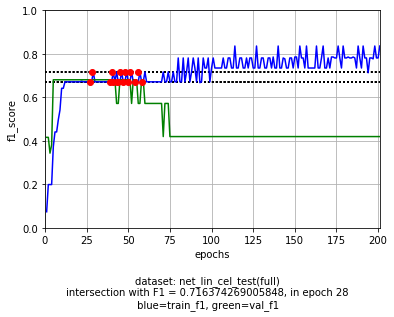

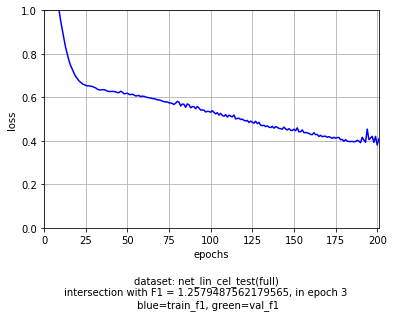

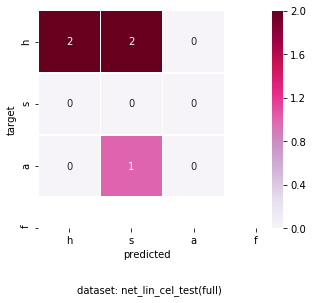

In [162]:
run("test", "full", "cel")